# Тестовое задание: оценка и анализ качества разметки медицинских снимков.

---

## Описание

### Данные

К заданию приложены 3 csv файла - `Гидраторакс.csv`, `Очаг.csv`, `Снижение пневматизации.csv`.

Содержимое файлов представляет из себя разметку медицинских снимков несколькими врачами. Другими словами, 15 разных врачей разметили 476 снимка на факт наличия или отсутствия патологии (1 - патология есть, 0 - нет). Каждый файл соответствует разметке одной патологии.

Формат колонок файлов:

**ID Файла -** уникальный идентификатор снимка

**Врач№\{уникальный идентификатор врача\} -** разметка врачом данного снимка: 1 - врач определил наличие патологии, 0 - врач определил отсутствие патологии

### Что необходимо сделать

1. Оценить качество разметки каждого врача по каждой патологии. Построить графики хорошо отображающие информацию по качеству разметки каждого врача. **Подсказка:** качество можно сравнивать как среднее отклонение от усредненной по всем врачам разметке или как среднюю ковариацию со всеми другими врачами, можно придумать и другие способы
2. Отберите худших врачей по каждой из патологий. **Комментарий:** Необходимо описать принцип отбора
3. Сформируйте итоговую разметку (для каждого снимка только одно значение 0 или 1). А также уверенность в разметке каждого снимка. **Комментарий**: критерий уверенности в разметке предлагается выбрать самим
4. Оцените итоговое качество разметки по каждой из патологий. **Комментарий:** необходимо получить численную оценку, а также можно привести комментарии с доводами о качестве разметки

---

### Загрузка данных и необходимых модулей

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
hydro = pd.read_csv('Гидроторакс.csv')
focus = pd.read_csv('Очаг.csv')
reduc_pneu = pd.read_csv('Снижение пневматизации.csv')

In [3]:
hydro.head()

,ID Файла,Врач№1,Врач№2,Врач№3,Врач№4,Врач№5,Врач№6,Врач№7,Врач№8,Врач№9,Врач№10,Врач№11,Врач№12,Врач№13,Врач№14,Врач№15
0,0,1,1,0,1,1,1,0,0,1,1,0,1,1,1,1
1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
2,2,0,1,0,1,0,0,0,0,0,0,0,0,1,1,1
3,3,0,1,0,1,0,1,0,0,0,0,0,0,1,1,1
4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


---

### Преобразование и анализ данных

Так как в данных отсутствует фактическая истинная разметка, то для начала применим консенсус-разметку на основе среднего и модального значения.

In [4]:
doctor_list = ['Врач№1', 'Врач№2', 'Врач№3', 'Врач№4', 'Врач№5', 
               'Врач№6','Врач№7', 'Врач№8', 'Врач№9', 'Врач№10', 
               'Врач№11', 'Врач№12','Врач№13', 'Врач№14', 'Врач№15']

for df in [hydro, focus, reduc_pneu]:
    df['target_prob'] = df[doctor_list].mean(axis=1).round(3)                     # средняя метка класса или вероятность класса 1
    df['mode_target'] = df['target_prob'].apply(lambda x: 1 if x >= 0.5 else 0)   # мода разметки

In [5]:
hydro.head(2)

,ID Файла,Врач№1,Врач№2,Врач№3,Врач№4,Врач№5,Врач№6,Врач№7,Врач№8,Врач№9,Врач№10,Врач№11,Врач№12,Врач№13,Врач№14,Врач№15,target_prob,mode_target
0,0,1,1,0,1,1,1,0,0,1,1,0,1,1,1,1,0.733,1
1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0.133,0


Наша задача относится к **классификации**, поэтому применим соответствующие метрики: **accuracy**, **precision** и **recall** (ещё добавим метрику предлагавшуюся авторами задачи - "Среднее отклонение от усреднённой разметки по всем врачам").

In [6]:
metric_list = ['hydro_MDP', 'focus_MDP', 'reduc_pneu_MDP', 
               'hydro_accur', 'focus_accur', 'reduc_pneu_accur', 
               'hydro_precision', 'focus_precision', 'reduc_pneu_precision', 
               'hydro_recall', 'focus_recall', 'reduc_pneu_recall']

doctor_metrics = pd.DataFrame(index=doctor_list, columns=metric_list)

for i, df in enumerate([hydro, focus, reduc_pneu]):
    for doctor in doctor_list:
        doctor_metrics.loc[doctor, metric_list[i]] = float(abs(df['target_prob'] - df[doctor]).mean())                 # Среднее отклонение от средней метки
        doctor_metrics.loc[doctor, metric_list[i+3]] = (df['mode_target'] == df[doctor]).sum() / df.shape[0]           # Accuracy
        doctor_metrics.loc[doctor, metric_list[i+6]] = (df['mode_target'] & df[doctor]).sum() / df[doctor].sum()       # Precision
        doctor_metrics.loc[doctor, metric_list[i+9]] = (df['mode_target'] & df[doctor]).sum() / df['mode_target'].sum()# Recall

In [7]:
doctor_metrics = doctor_metrics.astype(float)
doctor_metrics

,hydro_MDP,focus_MDP,reduc_pneu_MDP,hydro_accur,focus_accur,reduc_pneu_accur,hydro_precision,focus_precision,reduc_pneu_precision,hydro_recall,focus_recall,reduc_pneu_recall
Врач№1,0.108069,0.117581,0.147465,0.935010,0.943396,0.918239,0.842105,0.520000,0.638889,0.685714,0.896552,0.779661
Врач№2,0.147910,0.211908,0.144526,0.878407,0.807128,0.916143,0.549180,0.221239,0.743590,0.957143,0.862069,0.491525
Врач№3,0.121780,0.106952,0.152635,0.901468,0.955975,0.899371,0.960000,0.653846,0.607843,0.342857,0.586207,0.525424
Врач№4,0.112966,0.144130,0.151939,0.941300,0.888889,0.897275,0.723404,0.293103,0.575758,0.971429,0.586207,0.644068
Врач№5,0.149306,0.116864,0.150547,0.874214,0.949686,0.901468,0.562500,0.592593,0.593750,0.642857,0.551724,0.644068
Врач№6,0.206845,0.168595,0.187025,0.807128,0.870021,0.844864,0.429487,0.291139,0.441860,0.957143,0.793103,0.966102
Врач№7,0.118128,0.153904,0.159491,0.922432,0.884696,0.888889,0.811321,0.283333,0.607143,0.614286,0.586207,0.288136
Врач№8,0.132941,0.145094,0.192057,0.888889,0.882600,0.828092,0.774194,0.034483,0.274510,0.342857,0.034483,0.237288
Врач№9,0.124841,0.116180,0.150124,0.909853,0.943396,0.907757,0.666667,0.526316,0.592593,0.771429,0.689655,0.813559
Врач№10,0.110866,0.121488,0.163679,0.930818,0.926625,0.888889,0.746667,0.437500,0.534091,0.800000,0.724138,0.796610


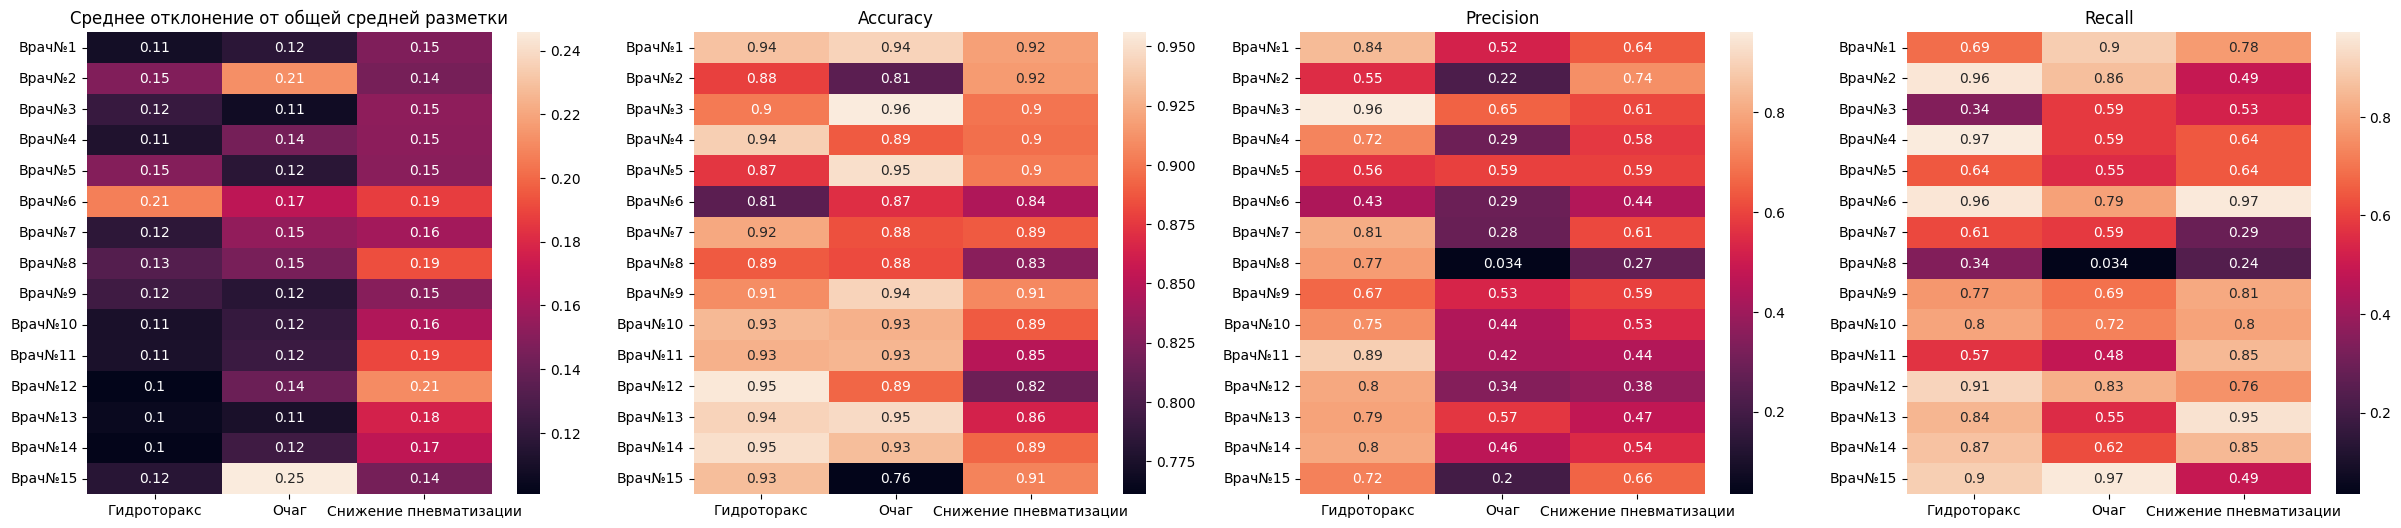

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(30, 6))
mean_deviation_predict_heatmap = sns.heatmap(doctor_metrics[metric_list[:3]], annot=True, ax=axes[0])
mean_deviation_predict_heatmap.set_title('Среднее отклонение от общей средней разметки')
mean_deviation_predict_heatmap.set_ylabel('')
mean_deviation_predict_heatmap.set_xticklabels(['Гидроторакс', 'Очаг', 'Снижение пневматизации'])

accuracy_predict_heatmap = sns.heatmap(doctor_metrics[metric_list[3:6]], annot=True, ax=axes[1])
accuracy_predict_heatmap.set_title('Accuracy')
accuracy_predict_heatmap.set_ylabel('')
accuracy_predict_heatmap.set_xticklabels(['Гидроторакс', 'Очаг', 'Снижение пневматизации'])

precision_predict_heatmap = sns.heatmap(doctor_metrics[metric_list[6:9]], annot=True, ax=axes[2])
precision_predict_heatmap.set_title('Precision')
precision_predict_heatmap.set_ylabel('')
precision_predict_heatmap.set_xticklabels(['Гидроторакс', 'Очаг', 'Снижение пневматизации'])

recall_predict_heatmap = sns.heatmap(doctor_metrics[metric_list[9:12]], annot=True, ax=axes[3])
recall_predict_heatmap.set_title('Recall')
recall_predict_heatmap.set_ylabel('')
recall_predict_heatmap.set_xticklabels(['Гидроторакс', 'Очаг', 'Снижение пневматизации']);

'Среднее отклонение от общей средней разметки' и accuracy сильно коррелируют, но обе эти метрики мало полезны для нашего анализа.

Так как данные об **опасных патологиях**, то необходимо обнаружить как можно больше потенциально больных пациентов для дальнейших уточняющих медицинских исследований . В этой задаче поможет метрика **recall**, так как чем больше эта метрика, тем большую часть потенциально больных может определить врач (важно свести к минимуму ложно-отрицательные результаты).

Тем самым:

1. Метрика **recall** хорошо подходит для оценки качества разметки каждого врача по каждой патологии.

2. По тепловой карте метрики **recall** и дополнительно проверяя по **precision** (точность разметки класса 1) можно сделать вывод что, самым худшим врачём по всем паталогиям является 'Врач№8', т.к. у него самая маленькая "полнота" и "точность" обнаружения патологии. Ещё можно заметить что 'Врач№6' хотя и имеет хороший recall, обладает очень низким precision. Откуда можно сделать вывод, что он сильно перестраховывается, т.е. ставит наличие патологии пациентам которые здоровы. Это может негативно отразиться на финансовых показателях, если дополнительные медицинские исследования очень дорогостоящие.

3. Теперь используя метрику **recall**, в зависимости от патологии можно присвоить весовые коэффициенты каждому врачу и масштабировать их так чтобы сумма коэффициентов равнялась единице. Затем вычислим взвешенную оценку принадлежности наблюдения к тому или иному классу, тем самым сформируем итоговую разметку и критерий уверенности в разметке (вероятность класса 1).

In [9]:
# Вычисляем весовые коэффициенты
coeff_columns = ['hydro', 'focus', 'reduc_pneu']
doctor_coeff = pd.DataFrame(index=doctor_list)

for col in coeff_columns:
    temp_df = doctor_metrics[col+'_recall']
    temp_df = (temp_df - temp_df.min()) / (temp_df.max() - temp_df.min())    # MinMax - масштабирование
    temp_df = temp_df/temp_df.sum()                                          
    doctor_coeff[col+'_coeff'] = temp_df

In [10]:
doctor_coeff

,hydro_coeff,focus_coeff,reduc_pneu_coeff
Врач№1,0.056738,0.093284,0.083117
Врач№2,0.101655,0.089552,0.038961
Врач№3,0.000000,0.059701,0.044156
Врач№4,0.104019,0.059701,0.062338
Врач№5,0.049645,0.055970,0.062338
Врач№6,0.101655,0.082090,0.111688
Врач№7,0.044917,0.059701,0.007792
Врач№8,0.000000,0.000000,0.000000
Врач№9,0.070922,0.070896,0.088312
Врач№10,0.075650,0.074627,0.085714


Теперь когда мы имеем весовые коэффициенты, проведём разметку с помощью скалярного произведения векторов.

In [11]:
# Скалярно умножаем вектор разметок снимка на вектор весов (по патологии)
for idx, df in enumerate([hydro, focus, reduc_pneu]):
    df['final_target_prob'] = df[doctor_list].apply(lambda x: np.dot(x.values, doctor_coeff[coeff_columns[idx]+'_coeff'].values), axis=1) # Вероятность принадлежности классу 1
    df['final_target'] = df['final_target_prob'].apply(lambda x: 1 if x >= 0.5 else 0)                                                    # Итоговая разметка

In [12]:
hydro.head()

,ID Файла,Врач№1,Врач№2,Врач№3,Врач№4,Врач№5,Врач№6,Врач№7,Врач№8,Врач№9,Врач№10,Врач№11,Врач№12,Врач№13,Врач№14,Врач№15,target_prob,mode_target,final_target_prob,final_target
0,0,1,1,0,1,1,1,0,0,1,1,0,1,1,1,1,0.733,1,0.917258,1
1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0.133,0,0.151300,0
2,2,0,1,0,1,0,0,0,0,0,0,0,0,1,1,1,0.333,0,0.468085,0
3,3,0,1,0,1,0,1,0,0,0,0,0,0,1,1,1,0.400,0,0.569740,1
4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0,0.000000,0


Теперь посмотрим что у нас изменилось:

* Посчитаем дисперсию вероятностей
* Как изменилось количество обнаруженных патологий
* И как изменилась средняя вероятность обнаружения патологии.

In [13]:
for df, name in [(hydro,'Гидроторакс'), (focus, 'Очаг'), (reduc_pneu, 'Снижение пневматизации')]:
    print('\n  ', name)
    print('\nДисперсия вероятностей:')
    print(df[['target_prob', 'final_target_prob']].var()[0:2])
    print('Изминение на: ', round(df[['target_prob', 'final_target_prob']].var().pct_change()[1]*100),' %\n')
    
    print('Количество обнаруженных патологий:')
    print(df[['mode_target', 'final_target']].sum()[0:2], '\n')
    
    print('Средняя вероятность наличия патологии:')
    print('Прошлое значение:', round(df[df['target_prob'] > 0.5]['target_prob'].mean()*100), 
          '%  Новое значение:', round(df[df['final_target_prob'] > 0.5]['final_target_prob'].mean()*100), '%')


   Гидроторакс

Дисперсия вероятностей:
target_prob          0.071651
final_target_prob    0.091948
dtype: float64
Изминение на:  28  %

Количество обнаруженных патологий:
mode_target     70
final_target    83
dtype: int64 

Средняя вероятность наличия патологии:
Прошлое значение: 75 %  Новое значение: 80 %

   Очаг

Дисперсия вероятностей:
target_prob          0.031988
final_target_prob    0.039738
dtype: float64
Изминение на:  24  %

Количество обнаруженных патологий:
mode_target     29
final_target    40
dtype: int64 

Средняя вероятность наличия патологии:
Прошлое значение: 65 %  Новое значение: 68 %

   Снижение пневматизации

Дисперсия вероятностей:
target_prob          0.052472
final_target_prob    0.072067
dtype: float64
Изминение на:  37  %

Количество обнаруженных патологий:
mode_target     59
final_target    76
dtype: int64 

Средняя вероятность наличия патологии:
Прошлое значение: 67 %  Новое значение: 73 %


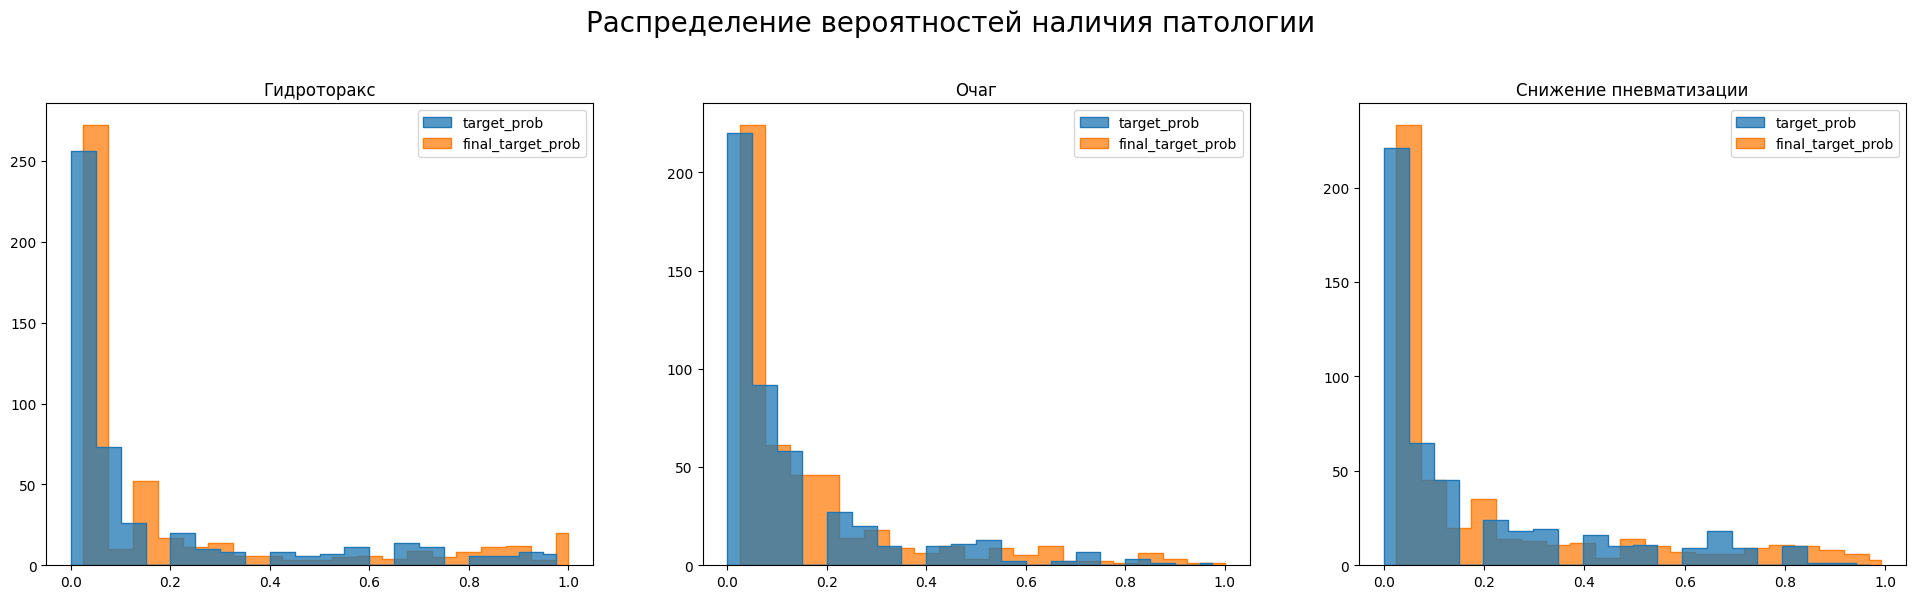

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 6))
fig.text(x=0.35, y=1, s='Распределение вероятностей наличия патологии', fontdict={'fontsize':20})
hydro_hm = sns.histplot(hydro[['target_prob', 'final_target_prob']], element='step', multiple='dodge', bins=20, ax=axes[0])
hydro_hm.set_title('Гидроторакс')
hydro_hm.set_ylabel('')
focus_hm = sns.histplot(focus[['target_prob', 'final_target_prob']], element='step', multiple='dodge', bins=20, ax=axes[1])
focus_hm.set_title('Очаг')
focus_hm.set_ylabel('')
reduc_pneu_hm = sns.histplot(reduc_pneu[['target_prob', 'final_target_prob']], element='step', multiple='dodge', bins=20, ax=axes[2])
reduc_pneu_hm.set_title('Снижение пневматизации')
reduc_pneu_hm.set_ylabel('');

4. Благодаря анализу и развесовке по врачам, удалось увеличить дисперсию вероятностей итоговой разметки: 'Гидроторакс', 'Очаг', 'Снижение пневматизации' на 28%, 24% и 37% соответственно, т.е. распределения вероятностей сместились ближе к краям диапозона 0-100% (что подтверждается увеличением "средней вероятности наличия патологии" на 5%, 3% и 6% соответственно), тем самым улучшив качество и уверенность итоговой разметки. Также удалось увеличить количество обнаружений потенциально больных пациентов на 13, 11 и 17 чел. соответственно.

---

#### Спасибо большое за интересное задание!